In [60]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
import tensorflow as tf
import datetime
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [62]:
#load cifar10 dataset and split it
cifar = tfds.load("cifar10", split=["train","test"], as_supervised=True)

train_ds = cifar[0]
val_ds = cifar[1]

In [63]:
batchsize = 8

In [64]:
for img1, label in train_ds.take(1):
  print(img1.shape, label.shape)

(32, 32, 3) ()


In [65]:
def prepare_cifar10_data(cifar10, batchsize=4):
    # Convert data from uint8 to float32
    cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Sloppy input normalization, bringing image values from range [0, 255] to [-1, 1]
    cifar10 = cifar10.map(lambda img, target: ((img / 128.) - 1., target))
    # Create one-hot targets
    cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # Cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar10 = cifar10.cache()
    # Shuffle, batch, prefetch
    cifar10 = cifar10.shuffle(1000)
    cifar10 = cifar10.batch(batchsize)
    cifar10 = cifar10.prefetch(20)
    # Return preprocessed dataset
    return cifar10

In [66]:
train_dataset = prepare_cifar10_data(train_ds)
val_dataset = prepare_cifar10_data(val_ds)

In [67]:
for img1, label in train_ds.take(1):
  print(img1.shape, label.shape)

(32, 32, 3) ()


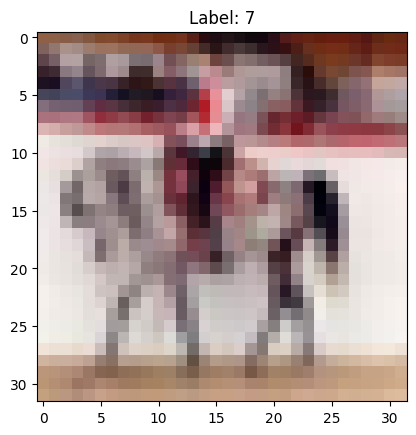

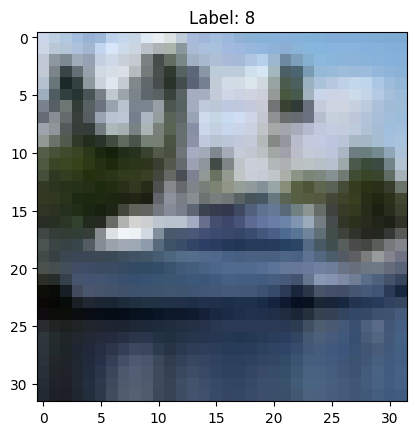

In [68]:
for img1, label in train_ds.take(2):
    # Convert image tensor to numpy array
    image_np = img1.numpy()

    # Display the image
    plt.imshow(image_np)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [69]:
class MLPModel(tf.keras.Model):
  def __init__(self):
    super(MLPModel, self).__init__()

    self.conv_layer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu")
    self.conv_layer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu")
    self.maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2)

    self.conv_layer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu")
    self.conv_layer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu")
    self.globalpooling_layer = tf.keras.layers.GlobalAveragePooling2D()

    self.out = tf.keras.layers.Dense(10, activation="softmax")

  def call(self, x):
    x =  self.conv_layer1(x)
    x =  self.conv_layer2(x)
    x =  self.maxpool_layer(x)
    x =  self.conv_layer3(x)
    x =  self.conv_layer4(x)
    x =  self.globalpooling_layer(x)
    y =  self.out(x)
    return y

In [70]:
basic_model = MLPModel()

In [72]:
def train_test_cafar_model(train_ds, test_ds, model, loss_func, optimizer, num_epochs):
  # Initialize lists to store training and test loss and accuracy
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  # Initialize the accuracy metrics
  train_accuracy_metric = tf.keras.metrics.Accuracy()
  test_accuracy_metric = tf.keras.metrics.Accuracy()

  for epoch in range(num_epochs):
    # Training
    total_train_loss = 0.0
    train_accuracy_metric.reset_states()

    for inputs, labels in train_ds:
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            train_loss = loss_func(labels, outputs)

        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_train_loss += train_loss.numpy()
        train_accuracy_metric.update_state(tf.argmax(labels, axis=1), tf.argmax(outputs, axis=1))

    average_train_loss = total_train_loss / len(train_ds)
    train_accuracy = train_accuracy_metric.result().numpy()

    # Testing
    total_test_loss = 0.0
    test_accuracy_metric.reset_states()

    for test_inputs, test_labels in test_ds:
        test_outputs = model(test_inputs)
        test_loss = loss_func(test_labels, test_outputs)

        total_test_loss += test_loss.numpy()
        test_accuracy_metric.update_state(tf.argmax(test_labels, axis=1), tf.argmax(test_outputs, axis=1))

    average_test_loss = total_test_loss / len(test_ds)
    test_accuracy = test_accuracy_metric.result().numpy()

    # Print or log the values
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Store values for plotting
    train_loss_list.append(average_train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(average_test_loss)
    test_accuracy_list.append(test_accuracy)

  return (train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)

In [73]:
basic_model = MLPModel()
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=0.8)
num_epochs = 5

In [74]:
#(train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list) = train_test_cafar_model(train_dataset, val_dataset, basic_model, cce, optimizer_Adam, num_epochs)

In [75]:
basic_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
#path for saving the logs
path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)

In [76]:
basic_model.fit(train_dataset, epochs = 5, callbacks = [tensorboard_callback])

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
basic_model.summary()